In [45]:
import sys
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime, timedelta
from random import randrange, randint
import numpy as np
import math
from tqdm import tqdm
import csv
import random
import string
import itertools

In [46]:
# Задаём число аккаунтов в сети и общее число токенов

n = 1500 
G = nx.complete_graph(n)
token_supply = 100000000
token_distribution = {'exchange':0.05}


In [47]:
def random_n_digits(n):
    range_start = 10**(n-1)
    range_end = (10**n)-1
    return randint(range_start, range_end)

def generate_addresses(graph):
    for node in graph.nodes():
        graph.node[node]['address'] = 'g'+str(random_n_digits(4))+str(random.choice(string.ascii_lowercase))+\
        str(random_n_digits(4))+random.choice(string.ascii_lowercase)+str(random_n_digits(4))

In [48]:
# Распределяем роли в сети и их количество

ro = [0.001, 0.294, 0.4, 0.3, 0]

roles = {'exchange':int(ro[0]*n), 
         'buyer':int(ro[1]*n), 
         'seller':int(ro[2]*n), 
         'hodler':int(ro[3]*n), 
         'business':int(n-(sum(ro[0:4]))*n)}


for node in G.nodes()[0:roles['exchange']]:
    G.node[node]['account_type'] = 'exchange'
for node in G.nodes()[roles['exchange']:roles['exchange']+roles['buyer']]:
    G.node[node]['account_type'] = 'buyer'
for node in G.nodes()[roles['exchange']+roles['buyer']:
                      roles['exchange']+roles['buyer']+roles['seller']]:
    G.node[node]['account_type'] = 'seller'
for node in G.nodes()[roles['exchange']+roles['buyer']+roles['seller']:
                      roles['exchange']+roles['buyer']+roles['seller']+roles['hodler']]:
    G.node[node]['account_type'] = 'hodler'
for node in G.nodes()[roles['exchange']+roles['buyer']+roles['seller']+roles['hodler']:n]:
    G.node[node]['account_type'] = 'business'


In [49]:
# Задаём макс. баланс токенов, доступный каждому из участников, его покупательную способность

def set_max_balances(G, token_supply):
    #normal = token_supply*(0.03*np.random.randn(1,n) + 0.1).tolist()[0]
    beta = np.random.beta(2, 9, n).tolist()
    dist = beta
    for node in G.nodes():
        if G.node[node]['account_type'] == 'exchange':
            G.node[node]['max_balance'] = 0.1*token_supply
        else:
            if dist[node] > 0:
                G.node[node]['max_balance'] = token_supply*dist[node]
            else:
                G.node[node]['max_balance'] = 1
    return (token_supply*min(dist), token_supply*max(dist))

# Задаём стартовую пустую историю транзакций между каждой парой пользователей

def set_initial_history(graph):
    for edge in G.edges():
        if edge[0] < edge[1]:
            G.edge[edge[0]][edge[1]]['tx_history'] = []
        

        
# Транзакция на ребре подразумевает, что первый аккаунт - отправитель, второй - получатель

def transaction(graph, edge, amount, timestamp):
    
           
    if (graph.node[edge[0]]['balance'] >= (amount+20) ) and\
    (graph.node[edge[1]]['balance'] + amount <= graph.node[edge[1]]['max_balance']) and\
    (graph.node[edge[0]]['send'] >= 1):
        #print(graph.node[edge[0]]['balance'], amount+20)
        graph.node[edge[0]]['balance'] -= (amount+20)
        graph.node[edge[1]]['balance'] += amount
        graph.node[edge[0]]['send'] -= 1
        graph.node[edge[1]]['receive'] += 1
        graph.edge[edge[0]][edge[1]]['tx_history'].append({'timestamp':timestamp,'from and to':edge,'amount':amount})
                
        return [datetime.fromtimestamp(timestamp).\
            strftime('%Y-%m-%dT%H:%M:%S'), graph.node[edge[0]]['address'], graph.node[edge[1]]['address'],\
            amount, 20]

    else:
        return []


In [50]:
'''
Первый вариант - генерируем времена транзакций с произвольными промежутками времени, i - количество транзакций
'''

def random_date(start,i):
    current = start
    while i >= 0:
        current = current + timedelta(minutes=randrange(10))
        yield current
        i-=1

'''
Второй вариант задания таймстампов - это уплотнение активности. Мы рассмотрим равномерную торговлю, экспоненциально
растущую торговлю, а также уплотнение торговли где-то посередине, задавая различные веса временным промежуткам
'''

#Делим интервал на желаемое число частей
def interval_divide(startDate, endDate, intervals):
    min = int(datetime.strptime(startDate, '%Y-%m-%d %H:%M:%S').strftime("%s"))
    max = int(datetime.strptime(endDate, '%Y-%m-%d %H:%M:%S').strftime("%s"))
    interval_size = round((max - min) / intervals)
    intervals_list = []
    start = min
    for start in range(min, max, interval_size):
        end = start + interval_size
        intervals_list.append([start, end])
    #print(intervals_list)
    return intervals_list

#Каждому интервалу с заданными вручную весами ставим в соответствие рандомную точку из этого интервала
def generate_weighted_activity(intervals, weights):
    weights = [w/sum(weights) for w in weights]
    tx_weighted_ts = []
    assert len(intervals) == len(weights)
    weighted_intervals = list(random.choices(intervals, weights, k=number_of_tx))
    for interval in weighted_intervals:
        tx_weighted_ts.append(random.uniform(interval[0], interval[1]))
    return tx_weighted_ts


In [51]:
#Проверяю число участников

exchange_count = 0
buyer_count = 0
seller_count = 0
hodler_count = 0
business_count = 0

for node in G.nodes():
    if G.node[node]['account_type'] == 'exchange':
        exchange_count += 1
    if G.node[node]['account_type'] == 'buyer':
        buyer_count += 1
    if G.node[node]['account_type'] == 'seller':
        seller_count += 1
    if G.node[node]['account_type'] == 'hodler':
        hodler_count += 1
    if G.node[node]['account_type'] == 'business':
        business_count += 1
        
'''
Здесь задаются параметры % от общей активности сети, приходящейся на ту или иную группу аккаунтов, 
и максимальное кол-во отправлений, доступных разным типам аакаунтов
'''

def set_max_activity(graph, tx_number, send):
    for node in graph.nodes():
        if graph.node[node]['account_type'] == 'exchange':
            graph.node[node]['send'] = send['exchange']*tx_number
            graph.node[node]['receive'] = 0
            
        if graph.node[node]['account_type'] == 'buyer':
            graph.node[node]['send'] = send['buyer']*tx_number
            graph.node[node]['receive'] = 0
            
        if graph.node[node]['account_type'] == 'seller':
            graph.node[node]['send'] = send['seller']*tx_number
            graph.node[node]['receive'] = 0
            
        if graph.node[node]['account_type'] == 'hodler':
            graph.node[node]['send'] = send['hodler']*tx_number
            graph.node[node]['receive'] = 0
            
        if graph.node[node]['account_type'] == 'business':
            graph.node[node]['send'] = send['business']*tx_number
            graph.node[node]['receive'] = 0



'''
Задаём стартовые балансы в сети, token_supply (type int)  - общее число токенов, token_distribution (type dictionary) - 
изначальное распределение токенов между биржей и пользователями, например 80% у биржи
'''

def set_start_balances(graph, token_supply, token_distribution):
    
    hodler_count = 0
    buyer_count = 0
    seller_count = 0
    business_count = 0
    beta = np.random.beta(2, 9, n).tolist()
    
    for node in G.nodes():
        
        if G.node[node]['account_type'] == 'exchange':
            
            G.node[node]['balance']  = token_distribution['exchange']*token_supply
        
        elif G.node[node]['account_type'] != 'exchange' and (1-token_distribution['exchange'])\
            *token_supply*beta[node]<=G.node[node]['max_balance']:
            
            G.node[node]['balance'] = (1-token_distribution['exchange'])*\
            token_supply*beta[node]
        
        else:
            
            G.node[node]['balance'] = G.node[node]['max_balance']
            #print(node, 'max_balance')
    
    #Нормируем число токенов на общую сумму
    token_sum = 0
    exchange_token_sum = 0
    for node in G.nodes():
        if G.node[node]['account_type'] != 'exchange':
            token_sum += G.node[node]['balance']
        else:
            exchange_token_sum += G.node[node]['balance']
    
    for node in G.nodes():
        if G.node[node]['account_type'] != 'exchange':
            G.node[node]['balance'] = G.node[node]['balance']/(token_sum/(token_supply-exchange_token_sum))


In [52]:
# b число бизнесов, активных в сети, c список количества клиентов у каждого бизнеса, а число атакующих
def clusters(graph, b, a, c):
    assert len(c) == b
    customers = {}
    b_a = list(random.sample(range(1, n), b+a))
    businesses = b_a[0:b]
    attackers = b_a[b:len(b_a)]
    non_businesses = [n for n in G.nodes() if n not in b_a]
    i = 0
    for business in businesses:
        customers[business] = list(random.sample(non_businesses, c[0]))
        i += 1
    return businesses, customers, attackers

In [53]:
def form_edges(businesses, clusters, attackers):
    b_to_c_edges = []
    c_to_b_edges = []
    for business in businesses:
        for customer in clusters[business]:
            b_to_c_edges.append((business, customer))
            c_to_b_edges.append((customer, business))
    a_edges = list(itertools.combinations(attackers, 2))
    return [b_to_c_edges, c_to_b_edges], a_edges

In [54]:
def generate_cluster_activity(graph, business_edges, attack_edges, timestamps):
    b1 = random.choices(business_edges, [0.1, 0.9], k=int(0.1*number_of_tx))
    b2 = [random.choice(el) for el in b1]
    a2 = random.choices(attack_edges, k=int(0.25*number_of_tx))
    b3 = random.sample(timestamps, int(0.35*number_of_tx))
    business_ts = b3[0:int(0.1*number_of_tx)]
    attack_ts = b3[int(0.1*number_of_tx):int(0.35*number_of_tx)]
    gen = [list(i) for i in zip(b2+a2,b3)]
    return gen, business_ts, attack_ts 

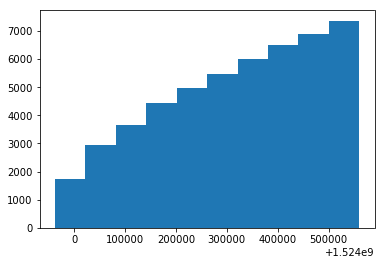

In [55]:
number_of_tx = 50000

#Задаём рост торговли в сети со временем
start = '2018-04-17 12:00:00'
end = '2018-04-24 12:00:00'
intervals = interval_divide(start, end, 100)
weights = [math.sqrt(0.5*t) for t in range(len(intervals))]

uneven_tx_ts = sorted(generate_weighted_activity(intervals, weights))

#Проверяем гистограмму числа транзакций в сети по временным интервалам
plt.hist(uneven_tx_ts)
plt.show()

#Просто произвольные временные точки
#startDate = datetime(2018, 4, 20, 12, 0, 0)
#tx_timestamps = []

#for x in list(random_date(startDate,number_of_tx)):
    #tx_timestamps.append(int(x.timestamp()))
    #print (x.strftime("%Y-%m-%d %H:%M:%s"))

In [73]:
#beta = np.random.beta(2, 9, n).tolist()
#dist = beta

In [56]:
generate_addresses(G)
set_max_balances(G, token_supply)
set_start_balances(G, token_supply, token_distribution)
set_initial_history(G)

#Сумма частоток для отправлений равна 1
send = {'exchange':0.02, 'buyer':0.33, 'seller':0.6, 'hodler':0.03, 'business':0.02}
set_max_activity(G, number_of_tx, send)

In [57]:
for node in G.nodes():
    with open('balances7.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(G.node[node]['address'] + str(G.node[node]['balance']))

In [72]:
client_list = [20, 30, 80, 20, 15, 25, 18, 10]

In [58]:
#Задаём число бизнесов и количество клиентов у каждого, клиенты могут пересекаться

businesses, groups, attackers = clusters(G, 8, 20, client_list)
b_edges, a_edges = form_edges(businesses, groups, attackers)
business_transactions, business_ts, attack_ts = \
generate_cluster_activity(G, b_edges, a_edges, uneven_tx_ts) 
business_transaction = sorted(business_transactions, key= lambda x: x[1])
business_ts = sorted(business_ts)
attack_ts = sorted(attack_ts)

In [59]:
#Сумма равна единице
receive = {'exchange':0.05, 'buyer':0.45, 'seller':0.3, 'hodler':0.05, 'business':0.15}

node_receiver_weights = []
node_sender_weights = []

for node in G.nodes():
    if G.node[node]['account_type'] == 'exchange':
        node_sender_weights.append(send['exchange']/exchange_count)
        node_receiver_weights.append(receive['exchange']/exchange_count)
    if G.node[node]['account_type'] == 'buyer':
        node_sender_weights.append(send['buyer']/buyer_count)
        node_receiver_weights.append(receive['buyer']/buyer_count)
    if G.node[node]['account_type'] == 'seller':
        node_sender_weights.append(send['seller']/seller_count)
        node_receiver_weights.append(receive['seller']/seller_count)
    if G.node[node]['account_type'] == 'hodler':
        node_sender_weights.append(send['hodler']/hodler_count)
        node_receiver_weights.append(receive['hodler']/hodler_count)
    if G.node[node]['account_type'] == 'business':
        node_sender_weights.append(send['business']/business_count)
        node_receiver_weights.append(receive['business']/business_count)
        
#Нормируем веса так, чтобы их сумма равнялась [приблизительно] единице
norm_sender_weights = [float(i)/sum(node_sender_weights) for i in node_sender_weights]
norm_receiver_weights = [float(i)/sum(node_receiver_weights) for i in node_receiver_weights]


#Выбираем k отправителей и получателей с заданными весами, которые определяют их частоту появления в транзакции
send_list = list(random.choices(G.nodes(), norm_sender_weights, k=number_of_tx))
receive_list = list(random.choices(G.nodes(), norm_receiver_weights, k=number_of_tx))

#Формируем пары отправитель и получатель, удаляем пары, где они совпали
network_edges = [t for t in list(zip(send_list, receive_list)) if t[0] != t[1]]


In [60]:
bc_edges = random.choices(b_edges[0]+b_edges[1], k=int(0.1*number_of_tx))
att_edges = random.choices(a_edges, k=int(0.25*number_of_tx))

In [61]:
#Запускаем торговлю между пользователями

b = 0
a = 0
e = 0
for t in tqdm(uneven_tx_ts):
    
    if t in business_ts:
        
        amount = random.uniform(100, 0.3*G.node[bc_edges[b][0]]['balance'])
        if (amount+20) > G.node[bc_edges[b][0]]['balance']:
            print("Can't make negative balance")
        
        else:
            with open('transaction_history7.csv', 'a', newline='') as csvfile:
                writer = csv.writer(csvfile, delimiter=';')
                writer.writerow(transaction(G, bc_edges[b], amount, t))
            #tx = transaction(G, bc_edges[b], amount, t)
            b += 1
            e += 1
            
    elif t in attack_ts:
        
        amount = random.uniform(0.8*G.node[att_edges[a][0]]['balance'], 0.9*G.node[att_edges[a][0]]['balance'])

        if (amount+20) > G.node[att_edges[a][0]]['balance']:
            print("Can't make negative balance")
        else: 
            with open('transaction_history7.csv', 'a', newline='') as csvfile:
                writer = csv.writer(csvfile, delimiter=';')
                writer.writerow(transaction(G, att_edges[a], amount, t))
            #tx = transaction(G, att_edges[a], amount, t)
            a += 1
            e += 1
      
    
    else:
        
        edge = network_edges[e]
        
        amount = random.uniform(100, 0.3*G.node[edge[0]]['balance'])
        if (amount+20) > G.node[edge[0]]['balance']:
            print("Can't make negative balance")
        else:
            with open('transaction_history7.csv', 'a', newline='') as csvfile:
                writer = csv.writer(csvfile, delimiter=';')
                writer.writerow(transaction(G, edge, amount, t))
            #tx = transaction(G, edge, amount, t)
            e += 1
    

  0%|          | 188/50000 [00:00<01:20, 620.70it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


  1%|          | 271/50000 [00:00<01:41, 492.20it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


  1%|          | 353/50000 [00:00<01:45, 469.18it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


  1%|          | 462/50000 [00:00<01:44, 473.95it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

  1%|          | 577/50000 [00:01<01:40, 490.00it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


  1%|▏         | 697/50000 [00:01<01:38, 501.34it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

  2%|▏         | 827/50000 [00:01<01:34, 519.76it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

  2%|▏         | 974/50000 [00:01<01:30, 543.56it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

  2%|▏         | 1142/50000 [00:01<01:25, 572.58it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

  3%|▎         | 1307/50000 [00:02<01:22, 593.34it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

  3%|▎         | 1592/50000 [00:02<01:16, 635.88it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

  4%|▎         | 1776/50000 [00:02<01:13, 656.21it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

  4%|▎         | 1867/50000 [00:02<01:12, 660.43it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

  4%|▍         | 2043/50000 [00:03<01:11, 670.72it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

  4%|▍         | 2211/50000 [00:03<01:10, 678.20it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

  5%|▍         | 2408/50000 [00:03<01:08, 695.54it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

  5%|▌         | 2608/50000 [00:03<01:06, 711.88it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

  6%|▌         | 2812/50000 [00:03<01:04, 726.19it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

  6%|▌         | 3007/50000 [00:04<01:03, 737.15it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

  6%|▋         | 3201/50000 [00:04<01:02, 746.47it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

  7%|▋         | 3394/50000 [00:04<01:02, 750.86it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

  7%|▋         | 3592/50000 [00:04<01:00, 760.94it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

  8%|▊         | 3785/50000 [00:04<01:00, 768.40it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

  8%|▊         | 3972/50000 [00:05<00:59, 771.39it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

  8%|▊         | 4152/50000 [00:05<00:59, 775.30it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

  9%|▊         | 4325/50000 [00:05<00:58, 774.34it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


  9%|▉         | 4509/50000 [00:05<00:58, 776.81it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

  9%|▉         | 4707/50000 [00:06<00:57, 783.83it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 10%|▉         | 4901/50000 [00:06<00:57, 788.77it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 10%|█         | 5099/50000 [00:06<00:56, 794.84it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 11%|█         | 5300/50000 [00:06<00:55, 800.94it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 11%|█         | 5498/50000 [00:06<00:55, 806.10it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 11%|█▏        | 5690/50000 [00:07<00:54, 807.01it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 12%|█▏        | 5781/50000 [00:07<00:54, 805.85it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 12%|█▏        | 5956/50000 [00:07<00:54, 807.71it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 12%|█▏        | 6157/50000 [00:07<00:54, 810.63it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 13%|█▎        | 6330/50000 [00:07<00:54, 806.93it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 13%|█▎        | 6496/50000 [00:08<00:53, 806.98it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 13%|█▎        | 6657/50000 [00:08<00:53, 806.35it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 14%|█▎        | 6846/50000 [00:08<00:53, 809.55it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 14%|█▍        | 7016/50000 [00:08<00:53, 807.15it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 14%|█▍        | 7192/50000 [00:08<00:52, 808.63it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 15%|█▍        | 7362/50000 [00:09<00:52, 807.86it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 15%|█▍        | 7444/50000 [00:09<00:52, 805.33it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 15%|█▌        | 7583/50000 [00:09<00:53, 791.01it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 15%|█▌        | 7726/50000 [00:09<00:53, 789.28it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 16%|█▌        | 7793/50000 [00:10<00:54, 778.65it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 16%|█▌        | 7943/50000 [00:10<00:54, 778.01it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 16%|█▌        | 8075/50000 [00:10<00:54, 774.66it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 16%|█▋        | 8209/50000 [00:10<00:54, 772.18it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 17%|█▋        | 8377/50000 [00:10<00:54, 767.72it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 17%|█▋        | 8574/50000 [00:11<00:53, 771.46it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 17%|█▋        | 8742/50000 [00:11<00:53, 771.32it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 18%|█▊        | 8910/50000 [00:11<00:53, 772.46it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 18%|█▊        | 8993/50000 [00:11<00:53, 770.14it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 18%|█▊        | 9069/50000 [00:11<00:53, 763.94it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 18%|█▊        | 9223/50000 [00:12<00:53, 761.30it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 19%|█▉        | 9389/50000 [00:12<00:53, 762.40it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 19%|█▉        | 9542/50000 [00:12<00:53, 761.12it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 19%|█▉        | 9690/50000 [00:12<00:53, 759.52it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 20%|█▉        | 9759/50000 [00:12<00:53, 753.23it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 20%|█▉        | 9837/50000 [00:13<00:53, 753.42it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 20%|█▉        | 9956/50000 [00:13<00:53, 743.06it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 20%|██        | 10094/50000 [00:13<00:53, 742.19it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 20%|██        | 10220/50000 [00:13<00:53, 740.26it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 21%|██        | 10370/50000 [00:14<00:53, 739.82it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 21%|██        | 10504/50000 [00:14<00:53, 736.10it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 21%|██▏       | 10650/50000 [00:14<00:53, 735.90it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 22%|██▏       | 10801/50000 [00:14<00:53, 733.02it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 22%|██▏       | 10865/50000 [00:14<00:53, 725.83it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 22%|██▏       | 11000/50000 [00:15<00:53, 725.15it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 22%|██▏       | 11061/50000 [00:15<00:53, 723.95it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 22%|██▏       | 11194/50000 [00:15<00:54, 717.61it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 23%|██▎       | 11365/50000 [00:15<00:53, 719.29it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 23%|██▎       | 11525/50000 [00:16<00:53, 719.99it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 23%|██▎       | 11699/50000 [00:16<00:53, 721.82it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 24%|██▎       | 11859/50000 [00:16<00:52, 721.60it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 24%|██▍       | 12022/50000 [00:16<00:52, 722.67it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 24%|██▍       | 12190/50000 [00:16<00:52, 723.67it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 25%|██▍       | 12370/50000 [00:17<00:51, 725.50it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 25%|██▍       | 12455/50000 [00:17<00:51, 724.58it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 25%|██▌       | 12605/50000 [00:17<00:51, 722.75it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 25%|██▌       | 12742/50000 [00:17<00:51, 721.07it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 26%|██▌       | 12871/50000 [00:17<00:51, 718.68it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 26%|██▌       | 13001/50000 [00:18<00:51, 716.78it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 26%|██▋       | 13164/50000 [00:18<00:51, 717.81it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 27%|██▋       | 13311/50000 [00:18<00:51, 717.89it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 27%|██▋       | 13470/50000 [00:18<00:50, 718.15it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 27%|██▋       | 13545/50000 [00:18<00:50, 717.42it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 27%|██▋       | 13688/50000 [00:19<00:50, 714.86it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 28%|██▊       | 13835/50000 [00:19<00:50, 714.97it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 28%|██▊       | 13905/50000 [00:19<00:50, 712.37it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 28%|██▊       | 14034/50000 [00:19<00:50, 711.51it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 28%|██▊       | 14157/50000 [00:19<00:50, 709.78it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 29%|██▊       | 14292/50000 [00:20<00:50, 707.64it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 29%|██▉       | 14433/50000 [00:20<00:50, 707.57it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 29%|██▉       | 14584/50000 [00:20<00:50, 707.99it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 29%|██▉       | 14731/50000 [00:20<00:49, 707.13it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 30%|██▉       | 14882/50000 [00:21<00:49, 707.01it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 30%|███       | 15022/50000 [00:21<00:49, 706.90it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 30%|███       | 15092/50000 [00:21<00:49, 705.42it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 30%|███       | 15236/50000 [00:21<00:49, 704.95it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 31%|███       | 15379/50000 [00:21<00:49, 704.16it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 31%|███       | 15526/50000 [00:22<00:48, 704.12it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 31%|███       | 15598/50000 [00:22<00:48, 704.16it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 32%|███▏      | 15805/50000 [00:22<00:48, 702.01it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 32%|███▏      | 15940/50000 [00:22<00:48, 701.47it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 32%|███▏      | 16069/50000 [00:22<00:48, 700.05it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 32%|███▏      | 16130/50000 [00:23<00:48, 698.60it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 32%|███▏      | 16243/50000 [00:23<00:48, 696.50it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 33%|███▎      | 16384/50000 [00:23<00:48, 696.29it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 33%|███▎      | 16527/50000 [00:23<00:48, 696.39it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 33%|███▎      | 16674/50000 [00:23<00:47, 696.70it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 34%|███▎      | 16811/50000 [00:24<00:47, 694.27it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 34%|███▍      | 16946/50000 [00:24<00:47, 693.64it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 34%|███▍      | 17010/50000 [00:24<00:47, 693.06it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 34%|███▍      | 17212/50000 [00:24<00:47, 692.74it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 35%|███▍      | 17278/50000 [00:24<00:47, 692.20it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 35%|███▍      | 17492/50000 [00:25<00:46, 692.33it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 35%|███▌      | 17636/50000 [00:25<00:46, 692.47it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 36%|███▌      | 17798/50000 [00:25<00:46, 693.24it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 36%|███▌      | 17964/50000 [00:25<00:46, 693.97it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 36%|███▋      | 18129/50000 [00:26<00:45, 694.92it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 37%|███▋      | 18301/50000 [00:26<00:45, 696.07it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 37%|███▋      | 18477/50000 [00:26<00:45, 697.07it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 37%|███▋      | 18648/50000 [00:26<00:44, 698.13it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 38%|███▊      | 18825/50000 [00:26<00:44, 699.17it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 38%|███▊      | 18992/50000 [00:27<00:44, 699.67it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 38%|███▊      | 19073/50000 [00:27<00:44, 699.28it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 38%|███▊      | 19218/50000 [00:27<00:44, 698.53it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 39%|███▊      | 19356/50000 [00:27<00:43, 697.03it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 39%|███▉      | 19509/50000 [00:27<00:43, 697.49it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 39%|███▉      | 19671/50000 [00:28<00:43, 698.23it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 40%|███▉      | 19831/50000 [00:28<00:43, 698.92it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 40%|███▉      | 19987/50000 [00:28<00:42, 699.40it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 40%|████      | 20143/50000 [00:28<00:42, 699.95it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 41%|████      | 20298/50000 [00:28<00:42, 700.15it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 41%|████      | 20457/50000 [00:29<00:42, 700.60it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 41%|████      | 20607/50000 [00:29<00:42, 699.46it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 42%|████▏     | 20755/50000 [00:29<00:41, 699.58it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 42%|████▏     | 20825/50000 [00:29<00:41, 698.56it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 42%|████▏     | 20968/50000 [00:30<00:41, 696.38it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 42%|████▏     | 21129/50000 [00:30<00:41, 697.08it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 43%|████▎     | 21280/50000 [00:30<00:41, 697.43it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 43%|████▎     | 21439/50000 [00:30<00:40, 697.81it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 43%|████▎     | 21600/50000 [00:30<00:40, 698.43it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 44%|████▎     | 21762/50000 [00:31<00:40, 698.97it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 44%|████▍     | 21920/50000 [00:31<00:40, 699.48it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 44%|████▍     | 22077/50000 [00:31<00:39, 699.86it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 44%|████▍     | 22231/50000 [00:31<00:39, 700.10it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 45%|████▍     | 22307/50000 [00:31<00:39, 699.08it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 45%|████▍     | 22441/50000 [00:32<00:39, 698.06it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 45%|████▌     | 22561/50000 [00:32<00:39, 696.67it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 45%|████▌     | 22703/50000 [00:32<00:39, 696.71it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 46%|████▌     | 22836/50000 [00:32<00:39, 696.05it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 46%|████▌     | 22975/50000 [00:33<00:38, 695.74it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 46%|████▋     | 23134/50000 [00:33<00:38, 696.32it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 47%|████▋     | 23287/50000 [00:33<00:38, 696.44it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 47%|████▋     | 23444/50000 [00:33<00:38, 696.92it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 47%|████▋     | 23520/50000 [00:33<00:37, 697.07it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 47%|████▋     | 23661/50000 [00:34<00:37, 694.89it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 48%|████▊     | 23795/50000 [00:34<00:37, 694.18it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 48%|████▊     | 23940/50000 [00:34<00:37, 694.05it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 48%|████▊     | 24075/50000 [00:34<00:37, 693.86it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 48%|████▊     | 24211/50000 [00:34<00:37, 693.54it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 49%|████▊     | 24349/50000 [00:35<00:36, 693.32it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 49%|████▉     | 24497/50000 [00:35<00:36, 693.47it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 49%|████▉     | 24654/50000 [00:35<00:36, 693.84it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 50%|████▉     | 24802/50000 [00:35<00:36, 693.66it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 50%|████▉     | 24872/50000 [00:35<00:36, 692.28it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 50%|█████     | 25012/50000 [00:36<00:36, 692.30it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 50%|█████     | 25162/50000 [00:36<00:35, 692.58it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 51%|█████     | 25302/50000 [00:36<00:35, 691.97it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 51%|█████     | 25446/50000 [00:36<00:35, 691.93it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 51%|█████     | 25579/50000 [00:37<00:35, 691.17it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 51%|█████▏    | 25642/50000 [00:37<00:35, 690.76it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 52%|█████▏    | 25758/50000 [00:37<00:35, 689.23it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 52%|█████▏    | 25885/50000 [00:37<00:35, 688.93it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 52%|█████▏    | 26037/50000 [00:37<00:34, 689.29it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 52%|█████▏    | 26184/50000 [00:37<00:34, 689.45it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 53%|█████▎    | 26330/50000 [00:38<00:34, 688.51it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 53%|█████▎    | 26453/50000 [00:38<00:34, 687.44it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 53%|█████▎    | 26568/50000 [00:38<00:34, 686.72it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 53%|█████▎    | 26625/50000 [00:38<00:34, 685.93it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 53%|█████▎    | 26726/50000 [00:39<00:34, 683.92it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 54%|█████▎    | 26819/50000 [00:39<00:33, 682.54it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 54%|█████▍    | 26920/50000 [00:39<00:33, 681.05it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 54%|█████▍    | 27023/50000 [00:39<00:33, 679.93it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 54%|█████▍    | 27070/50000 [00:39<00:33, 679.11it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 54%|█████▍    | 27215/50000 [00:40<00:33, 679.33it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 55%|█████▍    | 27473/50000 [00:40<00:33, 680.63it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 55%|█████▌    | 27633/50000 [00:40<00:32, 681.15it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 56%|█████▌    | 27801/50000 [00:40<00:32, 681.90it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 56%|█████▌    | 27964/50000 [00:40<00:32, 682.44it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 56%|█████▋    | 28136/50000 [00:41<00:32, 683.11it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 57%|█████▋    | 28309/50000 [00:41<00:31, 683.97it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 57%|█████▋    | 28476/50000 [00:41<00:31, 684.36it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 57%|█████▋    | 28556/50000 [00:41<00:31, 684.14it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 57%|█████▋    | 28700/50000 [00:41<00:31, 683.55it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 58%|█████▊    | 28831/50000 [00:42<00:31, 682.65it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 58%|█████▊    | 28975/50000 [00:42<00:30, 682.80it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 58%|█████▊    | 29042/50000 [00:42<00:30, 682.62it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 58%|█████▊    | 29198/50000 [00:42<00:30, 682.16it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 59%|█████▊    | 29351/50000 [00:43<00:30, 682.53it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 59%|█████▉    | 29507/50000 [00:43<00:30, 682.58it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 59%|█████▉    | 29653/50000 [00:43<00:29, 682.77it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 59%|█████▉    | 29726/50000 [00:43<00:29, 682.22it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 60%|█████▉    | 29862/50000 [00:43<00:29, 680.93it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 60%|█████▉    | 29997/50000 [00:44<00:29, 679.28it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 60%|██████    | 30124/50000 [00:44<00:29, 678.90it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 60%|██████    | 30183/50000 [00:44<00:29, 677.87it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 61%|██████    | 30303/50000 [00:44<00:29, 677.49it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 61%|██████    | 30440/50000 [00:44<00:28, 677.14it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 61%|██████▏   | 30669/50000 [00:45<00:28, 677.68it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 61%|██████▏   | 30742/50000 [00:45<00:28, 676.95it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 62%|██████▏   | 30876/50000 [00:45<00:28, 676.78it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 62%|██████▏   | 31033/50000 [00:45<00:28, 677.23it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 62%|██████▏   | 31193/50000 [00:46<00:27, 677.73it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 63%|██████▎   | 31357/50000 [00:46<00:27, 677.73it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 63%|██████▎   | 31432/50000 [00:46<00:27, 677.86it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 63%|██████▎   | 31507/50000 [00:46<00:27, 677.27it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 63%|██████▎   | 31632/50000 [00:46<00:27, 674.80it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 64%|██████▎   | 31768/50000 [00:47<00:27, 674.81it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 64%|██████▍   | 31900/50000 [00:47<00:26, 674.74it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 64%|██████▍   | 32068/50000 [00:47<00:26, 675.42it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 64%|██████▍   | 32240/50000 [00:47<00:26, 676.07it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 65%|██████▍   | 32417/50000 [00:47<00:25, 676.94it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 65%|██████▌   | 32672/50000 [00:48<00:25, 677.96it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 66%|██████▌   | 32757/50000 [00:48<00:25, 678.11it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 66%|██████▌   | 32924/50000 [00:48<00:25, 678.73it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 66%|██████▌   | 33087/50000 [00:48<00:24, 679.05it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 66%|██████▋   | 33242/50000 [00:48<00:24, 678.99it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 67%|██████▋   | 33384/50000 [00:49<00:24, 678.24it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 67%|██████▋   | 33450/50000 [00:49<00:24, 677.89it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 67%|██████▋   | 33574/50000 [00:49<00:24, 677.00it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 67%|██████▋   | 33692/50000 [00:49<00:24, 676.53it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 68%|██████▊   | 33837/50000 [00:50<00:23, 676.72it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 68%|██████▊   | 33986/50000 [00:50<00:23, 676.97it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 68%|██████▊   | 34157/50000 [00:50<00:23, 677.66it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 69%|██████▊   | 34326/50000 [00:50<00:23, 678.25it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 69%|██████▉   | 34511/50000 [00:50<00:22, 679.21it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 69%|██████▉   | 34700/50000 [00:51<00:22, 680.24it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 70%|██████▉   | 34879/50000 [00:51<00:22, 680.83it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 70%|███████   | 35055/50000 [00:51<00:21, 681.41it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 70%|███████   | 35217/50000 [00:51<00:21, 681.47it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 71%|███████   | 35368/50000 [00:51<00:21, 681.36it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 71%|███████   | 35522/50000 [00:52<00:21, 681.58it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 71%|███████▏  | 35679/50000 [00:52<00:21, 681.79it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 72%|███████▏  | 35843/50000 [00:52<00:20, 682.30it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 72%|███████▏  | 36003/50000 [00:52<00:20, 682.64it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 72%|███████▏  | 36159/50000 [00:52<00:20, 682.71it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 73%|███████▎  | 36330/50000 [00:53<00:20, 683.35it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 73%|███████▎  | 36514/50000 [00:53<00:19, 684.21it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 73%|███████▎  | 36685/50000 [00:53<00:19, 684.47it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 74%|███████▎  | 36841/50000 [00:53<00:19, 684.25it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 74%|███████▍  | 36914/50000 [00:53<00:19, 684.20it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 74%|███████▍  | 37049/50000 [00:54<00:18, 683.09it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 74%|███████▍  | 37182/50000 [00:54<00:18, 682.77it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 75%|███████▍  | 37337/50000 [00:54<00:18, 683.09it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 75%|███████▍  | 37499/50000 [00:54<00:18, 683.54it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 75%|███████▌  | 37665/50000 [00:55<00:18, 684.06it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 76%|███████▌  | 37829/50000 [00:55<00:17, 684.46it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 76%|███████▌  | 38001/50000 [00:55<00:17, 684.96it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 76%|███████▋  | 38180/50000 [00:55<00:17, 685.56it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 77%|███████▋  | 38354/50000 [00:55<00:16, 686.20it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 77%|███████▋  | 38544/50000 [00:56<00:16, 687.10it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 77%|███████▋  | 38724/50000 [00:56<00:16, 687.43it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 78%|███████▊  | 38808/50000 [00:56<00:16, 687.34it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 78%|███████▊  | 38960/50000 [00:56<00:16, 687.18it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 78%|███████▊  | 39116/50000 [00:56<00:15, 687.33it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 79%|███████▊  | 39275/50000 [00:57<00:15, 687.44it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 79%|███████▉  | 39440/50000 [00:57<00:15, 687.18it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 79%|███████▉  | 39603/50000 [00:57<00:15, 687.61it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 80%|███████▉  | 39758/50000 [00:57<00:14, 687.70it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 80%|███████▉  | 39915/50000 [00:58<00:14, 688.02it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 80%|███████▉  | 39992/50000 [00:58<00:14, 688.04it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 80%|████████  | 40141/50000 [00:58<00:14, 688.01it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 81%|████████  | 40281/50000 [00:58<00:14, 687.67it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance

 81%|████████  | 40407/50000 [00:58<00:13, 686.80it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 81%|████████  | 40533/50000 [00:59<00:13, 686.55it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 81%|████████  | 40594/50000 [00:59<00:13, 686.18it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 81%|████████▏ | 40729/50000 [00:59<00:13, 685.65it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 82%|████████▏ | 40858/50000 [00:59<00:13, 685.23it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance


 82%|████████▏ | 41012/50000 [00:59<00:13, 685.18it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 82%|████████▏ | 41234/50000 [01:00<00:12, 686.59it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 83%|████████▎ | 41468/50000 [01:00<00:12, 688.18it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 83%|████████▎ | 41701/50000 [01:00<00:12, 689.75it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 84%|████████▍ | 41927/50000 [01:00<00:11, 691.11it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 84%|████████▍ | 42154/50000 [01:00<00:11, 692.42it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 85%|████████▍ | 42376/50000 [01:01<00:10, 693.76it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 85%|████████▌ | 42607/50000 [01:01<00:10, 695.20it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 86%|████████▌ | 42846/50000 [01:01<00:10, 696.81it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 86%|████████▌ | 43082/50000 [01:01<00:09, 698.28it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 87%|████████▋ | 43315/50000 [01:01<00:09, 699.58it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 87%|████████▋ | 43551/50000 [01:02<00:09, 701.11it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 88%|████████▊ | 43789/50000 [01:02<00:08, 702.63it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 88%|████████▊ | 44029/50000 [01:02<00:08, 704.16it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 89%|████████▊ | 44262/50000 [01:02<00:08, 705.43it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 89%|████████▉ | 44480/50000 [01:02<00:07, 706.29it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 89%|████████▉ | 44584/50000 [01:03<00:07, 706.55it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 90%|████████▉ | 44789/50000 [01:03<00:07, 707.22it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 90%|████████▉ | 44996/50000 [01:03<00:07, 707.91it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 90%|█████████ | 45208/50000 [01:03<00:06, 709.00it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 91%|█████████ | 45420/50000 [01:03<00:06, 710.05it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 91%|█████████▏| 45641/50000 [01:04<00:06, 711.27it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 92%|█████████▏| 45870/50000 [01:04<00:05, 712.56it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 92%|█████████▏| 46104/50000 [01:04<00:05, 713.91it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 93%|█████████▎| 46335/50000 [01:04<00:05, 715.17it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 93%|█████████▎| 46563/50000 [01:04<00:04, 716.38it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 94%|█████████▎| 46795/50000 [01:05<00:04, 717.68it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 94%|█████████▍| 47018/50000 [01:05<00:04, 718.77it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 94%|█████████▍| 47128/50000 [01:05<00:03, 718.95it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 95%|█████████▍| 47336/50000 [01:05<00:03, 719.72it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 95%|█████████▌| 47534/50000 [01:05<00:03, 720.42it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 96%|█████████▌| 47754/50000 [01:06<00:03, 721.56it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 96%|█████████▌| 47982/50000 [01:06<00:02, 722.81it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 96%|█████████▋| 48200/50000 [01:06<00:02, 723.74it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 97%|█████████▋| 48426/50000 [01:06<00:02, 724.94it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 97%|█████████▋| 48645/50000 [01:07<00:01, 726.00it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 98%|█████████▊| 48861/50000 [01:07<00:01, 726.53it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 98%|█████████▊| 48959/50000 [01:07<00:01, 725.77it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 98%|█████████▊| 49160/50000 [01:07<00:01, 726.59it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

 99%|█████████▊| 49370/50000 [01:07<00:00, 727.53it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

 99%|█████████▉| 49555/50000 [01:08<00:00, 726.78it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

100%|█████████▉| 49771/50000 [01:08<00:00, 727.81it/s]


Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative

100%|██████████| 50000/50000 [01:08<00:00, 728.99it/s]

Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative balance
Can't make negative 

In [74]:
print('Start:', start)
print('End:', end)
print('Accounts:', n)
print('Transactions:', number_of_tx)
print('Token sypply:', token_supply)
print('Token distribution:', token_distribution)
print('Roles:', roles)
print('Sender and receiver weights:')
print(send)
print(receive)
print('Transaction fee:', 20)
print('Attackers:', len(attackers))
print('Businesses:', len(businesses))
print('Client number:', client_list)
print('Attackers')
for node in attackers:
    print(G.node[node]['address'])
print('Businesses')
for node in businesses:
    print(G.node[node]['address'])
print('Attack, business and regular transactions:')
print(b, a, e)

Start: 2018-04-17 12:00:00
End: 2018-04-24 12:00:00
Accounts: 1500
Transactions: 50000
Token sypply: 100000000
Token distribution: {'exchange': 0.05}
Roles: {'exchange': 1, 'buyer': 441, 'seller': 600, 'hodler': 450, 'business': 7}
Sender and receiver weights:
{'exchange': 0.02, 'buyer': 0.33, 'seller': 0.6, 'hodler': 0.03, 'business': 0.02}
{'exchange': 0.05, 'buyer': 0.45, 'seller': 0.3, 'hodler': 0.05, 'business': 0.15}
Transaction fee: 20
Attackers: 20
Businesses: 8
Client number: [20, 30, 80, 20, 15, 25, 18, 10]
Attackers
g5221s4547r3260
g9278o5071q5203
g2598f9715h5343
g9986b7185j2702
g3428h7514y8928
g6274z9794b2116
g4837x6947o8083
g9791s7006r6184
g1705o7632t9938
g3972m3037e3575
g3877g6261a8190
g9555n6924m6996
g8573y5762k3779
g9481a8543f3000
g6928v2008v1552
g3490i1893z3411
g3072b9355x4636
g5039b1359o1755
g6488y3486i5820
g8878a1570q3053
Businesses
g5065b7204b5364
g7236u4110y6086
g7749q4715h6733
g9018x4094f1484
g1674k9668v6047
g2135y9359c7564
g3640r9378p1116
g6958g1639q1887
Attack, 

In [ ]:
c = 0
for edge in G.edges():
    if G.edge[edge[0]][edge[1]]['tx_history'] != [] and len(G.edge[edge[0]][edge[1]]['tx_history']) > 1:
        print(len(G.edge[edge[0]][edge[1]]['tx_history']))
        print(G.edge[edge[0]][edge[1]]['tx_history'])
        c += 1
print(c)

g5221s4547r3260
g9278o5071q5203
g2598f9715h5343
g9986b7185j2702
g3428h7514y8928
g6274z9794b2116
g4837x6947o8083
g9791s7006r6184
g1705o7632t9938
g3972m3037e3575
g3877g6261a8190
g9555n6924m6996
g8573y5762k3779
g9481a8543f3000
g6928v2008v1552
g3490i1893z3411
g3072b9355x4636
g5039b1359o1755
g6488y3486i5820
g8878a1570q3053


g5065b7204b5364
g7236u4110y6086
g7749q4715h6733
g9018x4094f1484
g1674k9668v6047
g2135y9359c7564
g3640r9378p1116
g6958g1639q1887


In [64]:
for node in G.nodes():
    if G.node[node]['address'] == 'g5065b7204b5364':
        print(node, G.node[node])

782 {'account_type': 'seller', 'address': 'g5065b7204b5364', 'max_balance': 10258850.045780562, 'balance': 85334.301820683, 'send': 29661.0, 'receive': 316}


In [65]:
G.node[782]

{'account_type': 'seller',
 'address': 'g5065b7204b5364',
 'balance': 85334.301820683,
 'max_balance': 10258850.045780562,
 'receive': 316,
 'send': 29661.0}

In [ ]:
for edge in G.edges():
    if 782 in edge:
        if G.edge[edge[0]][edge[1]]['tx_history'] != []:
            for h in G.edge[edge[0]][edge[1]]['tx_history']:
                print(h['amount'])

In [68]:
ff = 55563.6762078773
l = 0
sent = 0
received = 0



for edge in G.edges():
    if 782 in edge:
        for h in G.edge[edge[0]][edge[1]]['tx_history']:
            if h['from and to'][0] == 782:
                #print('748 sender')
                ff -= (h['amount']+20)
                sent += (h['amount']+20)
                
            if h['from and to'][1] == 782:
                #print('748 receiver')
                ff += h['amount']
                received += h['amount']
                

In [69]:
print(55563.6762078773)
print(sent)
print(received)
print(ff)

55563.6762078773
3017414.9787674714
3047185.6043802765
85334.30182068294


In [ ]:
for edge in G.edges():
    if G.edge[edge[0]][edge[1]]['tx_history'] != []:
        print(G.edge[edge[0]][edge[1]])

In [ ]:
for node in G.nodes():
    if G.node[node]['address'] == 'g4490t9883q1674':
        print(node, G.node[node])

In [ ]:
ff = 32939.97119064471
l = 0
sent = 0
received = 0



for edge in G.edges():
    if 3 in edge:
        for h in G.edge[edge[0]][edge[1]]['tx_history']:
            if h['from and to'][0] == 3:
                
                ff -= (h['amount']+20)
                sent += (h['amount']+20)
                
            if h['from and to'][1] == 3:
                
                ff += h['amount']
                received += h['amount']

print(ff)